# Basic Examples of Batch Active Learning
This notebook contains some basic examples of batch active learning. The examples are computed for simple datasets where we can see the process visually. 

Example 1: Parabola dataset
- mcvopt acquisition function
- Dijkstra's Annulus Coreset
- LocalMax batch
- Naive batch

Example 2: Checkerboard dataset (used in paper)
- Dijkstra's Annulus Coreset
- LocalMax

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import graphlearning.active_learning as al
import graphlearning as gl
import batch_active_learning as bal

## Dataset generation
We make a simple dataset for the first batch active learning examples. 

In [2]:
#Create dataset
num_points = 2000
X = np.random.uniform(size = (num_points, 2))
labels = np.zeros(num_points, dtype=int)
labels[X[:, 1] - 3*(X[:, 0]-.5)**2 < .2] = 1

#Construct graph objects
W = gl.weightmatrix.knn(X, 20, kernel = 'distance')
G = gl.graph(W)
train_ind = []

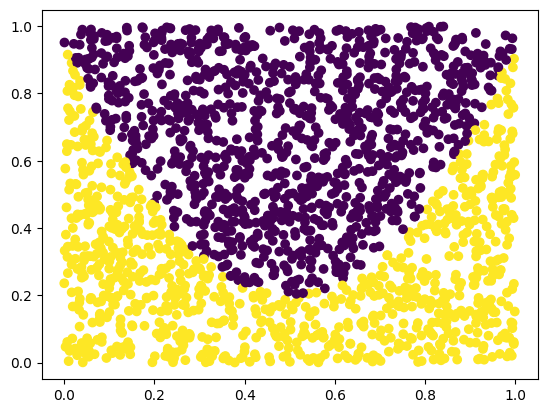

In [3]:
#Plot
fig0 = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.show()

## Active learning stuff
This part of the code demonstrates some basics of active learning. We first compute a coreset using Dijkstra's Annulus Coreset. Then we compare a batch generated by LocalMax with a batch generated by naively taking the top $batch\_size$ points of the acquisition function. We can see later that the naively generated batch has points with lots of overlap in the dataset. This experiment uses mcvopt. 

In [4]:
#Construct coreset using Dijkstras Annulus Coreset
coreset = bal.coreset_dijkstras(G, .5, data = X, density_info = (True, .2, 1.0), initial=list(train_ind));
print("Coreset = ", coreset)

Coreset =  [1534, 1195, 1980, 1503, 386, 985, 1817, 16, 1058, 377, 1146, 1572, 1958, 1434, 501, 742, 1259, 1697, 1438, 988]


In [5]:
#Compute mcvopt acquisition function
model = gl.ssl.laplace(W, None, reweighting='poisson')
acq = al.model_change_vopt()
act = al.active_learning(W, coreset, labels[coreset], eval_cutoff=min(200, len(X) // 2))
u = model.fit(act.current_labeled_set, act.current_labels)  # perform classification with GSSL classifier

act.candidate_inds = np.setdiff1d(act.training_set, act.current_labeled_set)
acq_vals = acq.compute_values(act, u)

modded_acq_vals = np.zeros(len(X))
modded_acq_vals[act.candidate_inds] = acq_vals

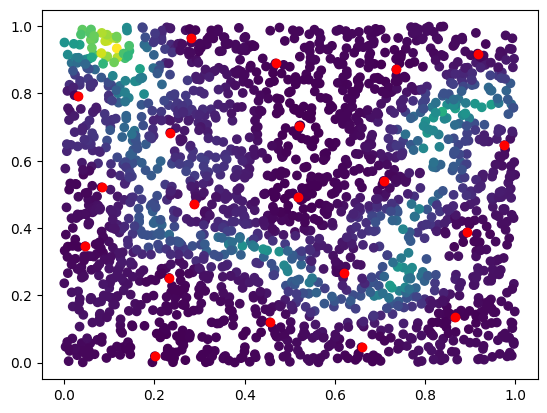

In [6]:
#Plot acquisition values and coreset
fig1 = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=modded_acq_vals)
plt.scatter(X[coreset, 0], X[coreset, 1], c='r')
plt.show()

In [7]:
#Compute new batch based on LocalMax
LM_batch, _, _ = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=1, method='Laplace',
                           display=False, use_prior=False, al_mtd='local_max', debug=False,
                           acq_fun='mcvopt', batchsize=5)
LM_batch = np.setdiff1d(LM_batch, coreset)
batch_size = len(LM_batch)

In [8]:
#Get the points of highest acquisition value
highest = np.argsort(modded_acq_vals)[-batch_size:]

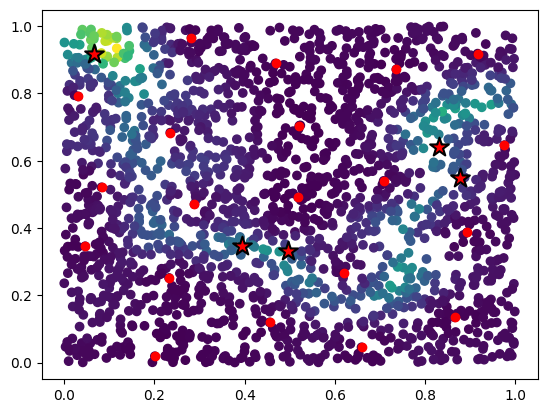

In [9]:
#Plot LocalMax batch
fig2 = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=modded_acq_vals)
plt.scatter(X[coreset, 0], X[coreset, 1], c='r')
plt.scatter(X[LM_batch, 0], X[LM_batch, 1], c='r', marker='*', s=200, edgecolors='k', linewidths=1.5)
plt.show()

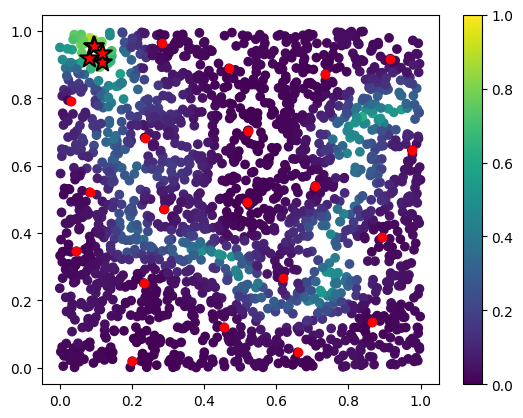

In [10]:
#Plot the naive batch
fig3 = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=modded_acq_vals)
plt.scatter(X[coreset, 0], X[coreset, 1], c='r')
plt.scatter(X[highest, 0], X[highest, 1], c='r', marker='*', s=200, edgecolors='k', linewidths=1.5)
tmp = plt.colorbar()
plt.show()

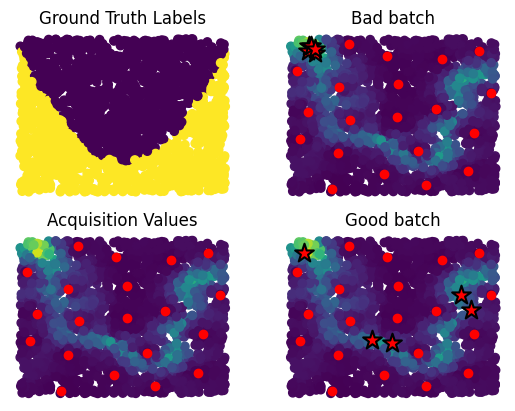

In [11]:
#Plot all of these plots together
fig_all = plt.figure()
plt.subplot(221) 
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.title("Ground Truth Labels")
plt.axis('off')

plt.subplot(222)
plt.scatter(X[:, 0], X[:, 1], c=modded_acq_vals)
plt.scatter(X[coreset, 0], X[coreset, 1], c='r')
plt.scatter(X[highest, 0], X[highest, 1], c='r', marker='*', s=200, edgecolors='k', linewidths=1.5)
plt.title("Bad batch")
plt.axis('off')

plt.subplot(223)
plt.scatter(X[:, 0], X[:, 1], c=modded_acq_vals)
plt.scatter(X[coreset, 0], X[coreset, 1], c='r')
plt.title("Acquisition Values")
plt.axis('off')

plt.subplot(224)
plt.scatter(X[:, 0], X[:, 1], c=modded_acq_vals)
plt.scatter(X[coreset, 0], X[coreset, 1], c='r')
plt.scatter(X[LM_batch, 0], X[LM_batch, 1], c='r', marker='*', s=200, edgecolors='k', linewidths=1.5)
plt.title("Good batch")
plt.axis('off')

plt.savefig("BAL Examples/SimpleBatchExamples.jpg")
plt.show()

## Checkerboard heatmap and local maxes
This example is shown in the paper. We first generate a coreset with Dijkstra's Annulus Coreset. Then we run one iteration of LocalMax with the uncertainty acquisition function. 

In [12]:
#Used for example figures in paper
np.random.seed(0)

#Make data set
X, labels = bal.gen_checkerboard_3(num_samples=5000)

In [13]:
#Create graph learning objects
W = gl.weightmatrix.knn(X, 20, kernel = 'distance')
G = gl.graph(W)

#Generate coreset
coreset = bal.coreset_dijkstras(G, .5, data = X, density_info = (True, .2, 1.0));
print("Coreset = ", coreset)

Coreset =  [3582, 4638, 2192, 1111, 1075, 4866, 1829, 4011, 1976, 1776, 1025, 3620, 4406, 3085, 3964, 1959, 3965, 3590, 639, 3250, 3215, 2875, 120, 4846, 1050]


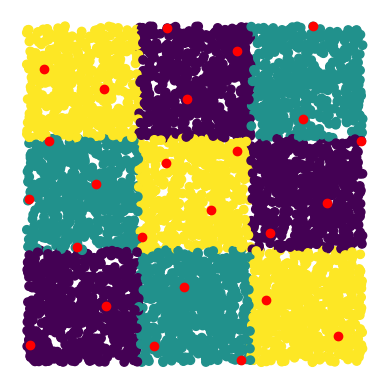

In [14]:
#Plot coreset on the classification
plt.scatter(X[:, 0], X[:, 1], c = labels)
plt.scatter(X[coreset, 0], X[coreset, 1], c='r')
plt.axis('square')
plt.axis('off')
plt.savefig('BAL Examples/checkerboard.jpg',bbox_inches='tight')
plt.show()

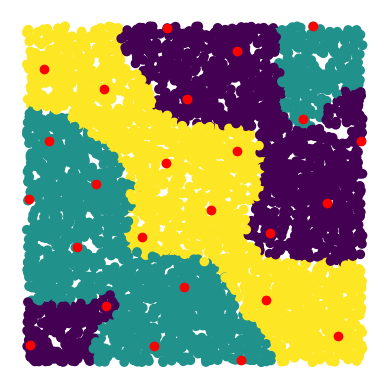

Size of coreset =  25
Using  0.5 % of the data
Current Accuracy is  79.15577889447236 %


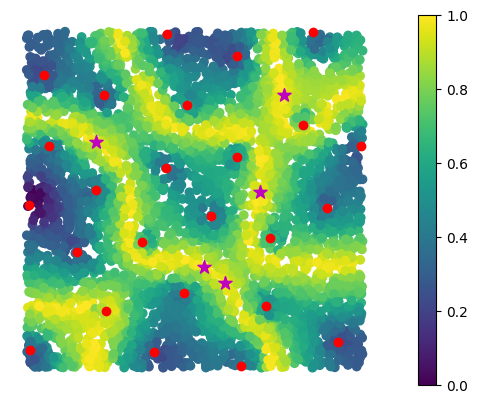

Next batch is [2598 1377 4894 3443  329]
Current number of labeled nodes 30
Current Accuracy is  80.20120724346077 %


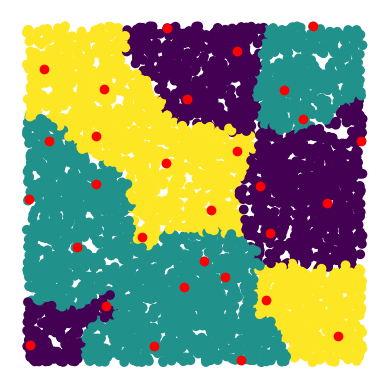

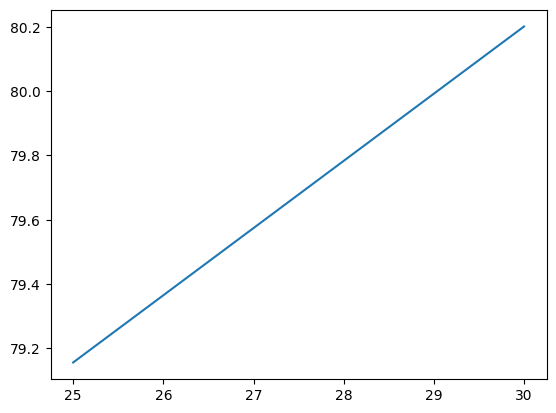

In [15]:
#Perform batch active learning with LocalMax
#The first and second images from the following experiment are used in the paper. 
#The third image shows the classifier after labelling the batch
#The final image is a graph of the accuracy as a function of the size of the labeled set. 
bal.coreset_run_experiment(X, labels, W, coreset, acq_fun='uc', display=True,
                           savefig=True, savefig_folder='BAL Examples/');